# Penalaan Parameter PID Menggunakan Deep Learning pada Kit iTCLab dan Pemantauannya Menggunakan Internet of Things (IoT)

![Deep-PID-iTCLab-IoT](DL07.jpg)
Proses penalaan nilai Kc, τI dan τD pada
pengendali PID menggunakan Deep Learning pada Kit iTCLab dan Pemantauannya Menggunakan Internet of Things (IoT)

In [1]:
import itclab
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
from paho.mqtt import client as mqtt_client

In [2]:
# Machine Learning - Building Datasets and Model
# Impor `Sequential` dari` keras.models`
from keras.models import Sequential

# Impor `Dense` dari` keras.layers`
from keras.layers import Dense

# Inisialisasi konstruktor
model = Sequential()

# Tambahkan lapisan masukan 
model.add(Dense(2, activation='sigmoid', input_shape=(2,)))

# Tambahkan satu lapisan tersembunyi
model.add(Dense(3, activation='sigmoid'))

# Tambahkan lapisan keluaran
model.add(Dense(3, activation='sigmoid'))

# Data Latih.
X = np.array([
    [1, 1],
    [0.4, 1.2],
    [1.2, 0.1],
    [1, 0.1]
])

# Label untuk Data Latih.
y = np.array([
    [0.25, 4.31, 0.20],
    [0.2, 4.1, 0.1],
    [0.1, 4.0, 0],
    [0.1, 4.0, 0]
])

# Bentuk keluaran model
model.output_shape

# Ringkasan model
model.summary()

# Konfigurasi model
model.get_config()

# Buat daftar semua tensor bobot 
model.get_weights()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 6         
                                                                 
 dense_1 (Dense)             (None, 3)                 9         
                                                                 
 dense_2 (Dense)             (None, 3)                 12        
                                                                 
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________


[array([[ 0.8056394 ,  0.41258848],
        [-0.28017998,  0.21165144]], dtype=float32),
 array([0., 0.], dtype=float32),
 array([[-0.11779463,  0.5934062 , -0.836638  ],
        [-0.97542006, -0.2639408 , -0.4029097 ]], dtype=float32),
 array([0., 0., 0.], dtype=float32),
 array([[ 0.07368827, -0.74909616,  0.8981495 ],
        [ 0.20042443, -0.9357164 ,  0.15049362],
        [ 0.00624037,  0.8084705 , -0.33550406]], dtype=float32),
 array([0., 0., 0.], dtype=float32)]

In [3]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                   
model.fit(X, y,epochs=100, batch_size=1, verbose=1)

Epoch 1/100
4/4 [==============================] - 0s 7ms/step - loss: 1.3724 - accuracy: 0.0000e+00
Epoch 2/100
4/4 [==============================] - 0s 0s/step - loss: 1.3510 - accuracy: 0.0000e+00
Epoch 3/100
4/4 [==============================] - 0s 3ms/step - loss: 1.3295 - accuracy: 0.0000e+00
Epoch 4/100
4/4 [==============================] - 0s 3ms/step - loss: 1.3081 - accuracy: 0.0000e+00
Epoch 5/100
4/4 [==============================] - 0s 4ms/step - loss: 1.2868 - accuracy: 0.0000e+00
Epoch 6/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2657 - accuracy: 0.0000e+00
Epoch 7/100
4/4 [==============================] - 0s 6ms/step - loss: 1.2445 - accuracy: 0.0000e+00
Epoch 8/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2235 - accuracy: 0.0000e+00
Epoch 9/100
4/4 [==============================] - 0s 3ms/step - loss: 1.2026 - accuracy: 0.0000e+00
Epoch 10/100
4/4 [==============================] - 0s 3ms/step - loss: 1.1818 - accuracy: 0

4/4 [==============================] - 0s 5ms/step - loss: -0.1445 - accuracy: 1.0000
Epoch 84/100
4/4 [==============================] - 0s 4ms/step - loss: -0.1608 - accuracy: 1.0000
Epoch 85/100
4/4 [==============================] - 0s 3ms/step - loss: -0.1770 - accuracy: 1.0000
Epoch 86/100
4/4 [==============================] - 0s 4ms/step - loss: -0.1932 - accuracy: 1.0000
Epoch 87/100
4/4 [==============================] - 0s 3ms/step - loss: -0.2094 - accuracy: 1.0000
Epoch 88/100
4/4 [==============================] - 0s 504us/step - loss: -0.2255 - accuracy: 1.0000
Epoch 89/100
4/4 [==============================] - 0s 2ms/step - loss: -0.2415 - accuracy: 1.0000
Epoch 90/100
4/4 [==============================] - 0s 3ms/step - loss: -0.2575 - accuracy: 1.0000
Epoch 91/100
4/4 [==============================] - 0s 4ms/step - loss: -0.2735 - accuracy: 1.0000
Epoch 92/100
4/4 [==============================] - 0s 4ms/step - loss: -0.2894 - accuracy: 1.0000
Epoch 93/100
4/4 [===

In [4]:
######################################################
# Use this script for evaluating model predictions   #
# and PID controller performance for the TCLab       #
# Adjust only PID and model sections                 #
######################################################

######################################################
# PID Controller                                     #
######################################################
# inputs -----------------------------------
# sp = setpoint
# pv = current temperature
# pv_last = prior temperature
# ierr = integral error
# dt = time increment between measurements
# outputs ----------------------------------
# op = output of the PID controller
# P = proportional contribution
# I = integral contribution
# D = derivative contribution
def pid(sp,pv,pv_last,ierr,dt):
    Kc   = 10.0 # K/%Heater
    tauI = 50.0 # sec
    tauD = 1.0  # sec
    # Parameters in terms of PID coefficients
    KP = Kc
    KI = Kc/tauI
    KD = Kc*tauD
    # ubias for controller (initial heater)
    op0 = 0 
    # upper and lower bounds on heater level
    ophi = 100
    oplo = 0
    # calculate the error
    error = sp-pv
    # calculate the integral error
    ierr = ierr + KI * error * dt
    # calculate the measurement derivative
    dpv = (pv - pv_last) / dt
    # calculate the PID output
    P = KP * error
    I = ierr
    D = -KD * dpv
    op = op0 + P + I + D
    # implement anti-reset windup
    if op < oplo or op > ophi:
        I = I - KI * error * dt
        # clip output
        op = max(oplo,min(ophi,op))
    # return the controller output and PID terms
    return [op,P,I,D]

In [5]:
######################################################
# PID Controller using Deep Learning                 #
######################################################
# inputs -----------------------------------
# sp = setpoint
# pv = current temperature
# pv_last = prior temperature
# ierr = integral error
# dt = time increment between measurements
# outputs ----------------------------------
# op = output of the PID controller
# P = proportional contribution
# I = integral contribution
# D = derivative contribution

def pid_dl(sp,pv,pv_last,ierr,dt):

    # calculate the error
    error = sp-pv
    d_error = sp-pv_last
    delta_error = (error - d_error)
    
    outDL = model.predict(np.array([[error,delta_error]]))
    
    Kc = outDL[0,0]
    tauI = outDL[0,1]
    tauD = outDL[0,2]
    
    # Parameters in terms of PID coefficients
    KP = Kc
    KI = Kc/tauI
    KD = Kc*tauD
    # ubias for controller (initial heater)
    op0 = 0 
    # upper and lower bounds on heater level
    ophi = 100
    oplo = 0

    # calculate the integral error
    ierr = ierr + KI * error * dt
    # calculate the measurement derivative
    dpv = (pv - pv_last) / dt
    # calculate the PID output
    P = KP * error
    I = ierr
    D = -KD * dpv
    op = op0 + P + I + D
    # implement anti-reset windup
    if op < oplo or op > ophi:
        I = I - KI * error * dt
        # clip output
        op = max(oplo,min(ophi,op))
    # return the controller output and PID terms
    return [op,P,I,D]

In [6]:
######################################################
# FOPDT model                                        #
######################################################
Kp = 0.5      # degC/%
tauP = 120.0  # seconds
thetaP = 10   # seconds (integer)
Tss = 23      # degC (ambient temperature)
Qss = 0       # % heater

######################################################
# Energy balance model                               #
######################################################
def heat(x,t,Q):
    # Parameters
    Ta = 23 + 273.15   # K
    U = 10.0           # W/m^2-K
    m = 4.0/1000.0     # kg
    Cp = 0.5 * 1000.0  # J/kg-K    
    A = 12.0 / 100.0**2 # Area in m^2
    alpha = 0.01       # W / % heater
    eps = 0.9          # Emissivity
    sigma = 5.67e-8    # Stefan-Boltzman

    # Temperature State 
    T = x[0]

    # Nonlinear Energy Balance
    dTdt = (1.0/(m*Cp))*(U*A*(Ta-T) \
            + eps * sigma * A * (Ta**4 - T**4) \
            + alpha*Q)
    return dTdt

In [7]:
# Connect to MQTT Broker for Monitoring
broker = 'broker.hivemq.com'
port = 1883
client_id = f'python-mqtt-{random.randint(0, 1000)}'

def connect_mqtt():
    def on_connect(client, userdata, flags, rc):
        if rc == 0:
            print("Connected to MQTT Broker!")
        else:
            print("Failed to connect, return code %d\n", rc)

    client = mqtt_client.Client(client_id)
    client.on_connect = on_connect
    client.connect(broker, port)
    return client

client = connect_mqtt()
client.loop_start()

Opening connection
Connected to MQTT Broker!
iTCLab connected via Arduino on port COM7
LED On
Running Main Loop. Ctrl-C to end.
  Time     SP     PV     Q1   =  P   +  I  +   D
   0.0  25.00  26.39   0.00   0.00   0.00   0.00


<Figure size 1000x700 with 0 Axes>

1/1 [==============================] - 0s 78ms/step
   1.0  25.00  26.42   0.00  -0.48   0.00  -0.00


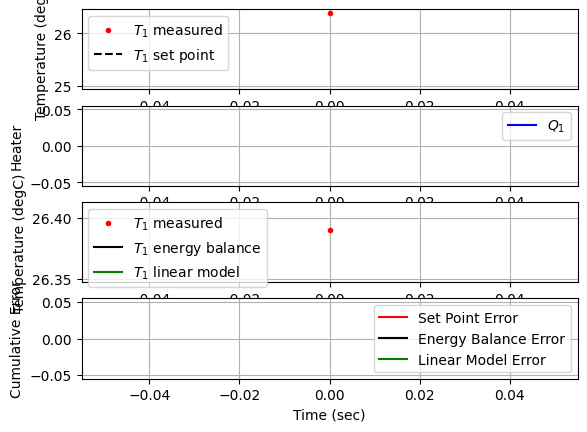

1/1 [==============================] - 0s 16ms/step
   2.0  25.00  26.33   0.00  -0.45   0.00   0.01


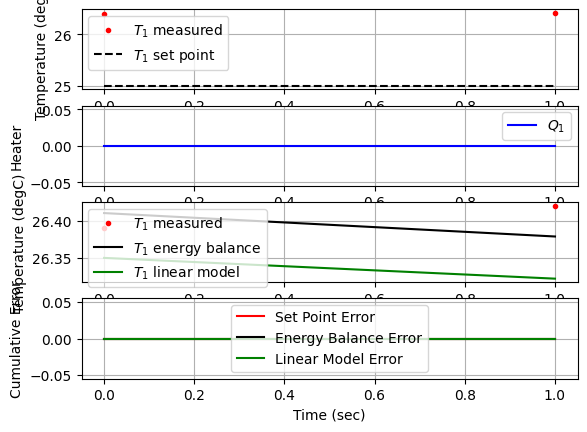

1/1 [==============================] - 0s 16ms/step
   3.0  25.00  26.41   0.00  -0.48   0.00  -0.01


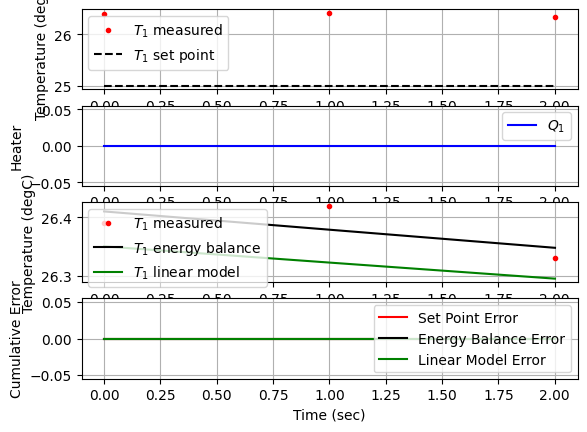

1/1 [==============================] - 0s 22ms/step
   4.0  25.00  26.32   0.00  -0.45   0.00   0.01


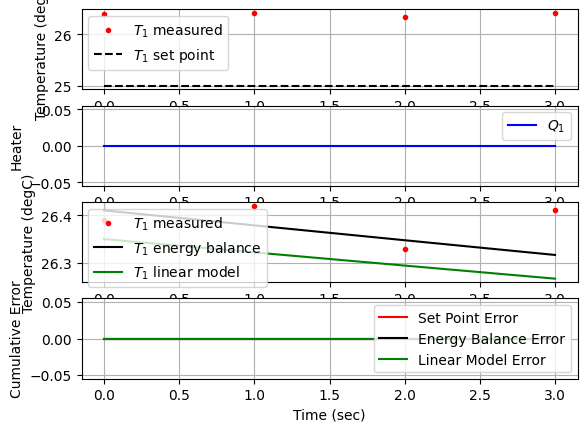

1/1 [==============================] - 0s 32ms/step
   5.0  25.00  26.39   0.00  -0.47   0.00  -0.01


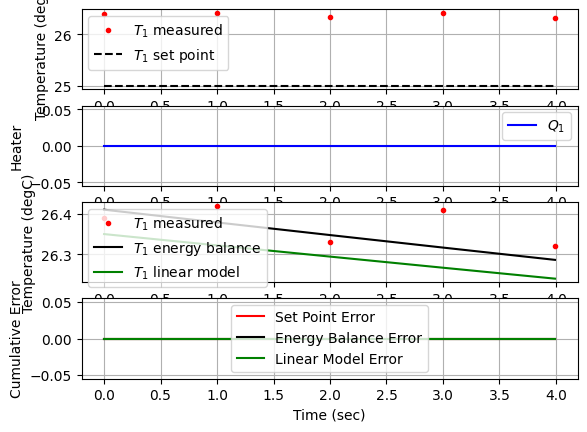

1/1 [==============================] - 0s 47ms/step
   6.0  25.00  26.35   0.00  -0.46   0.00   0.00


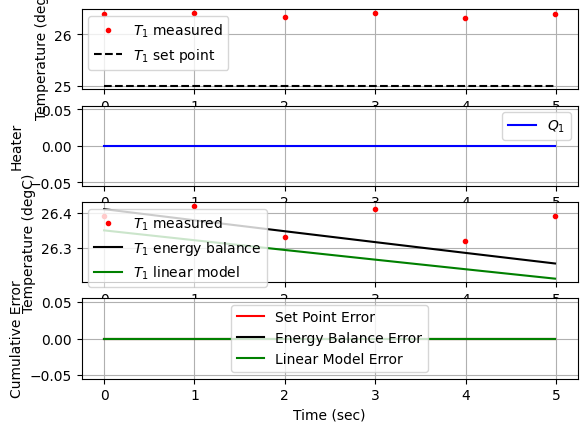

1/1 [==============================] - 0s 16ms/step
   7.0  25.00  26.41   0.00  -0.48   0.00  -0.01


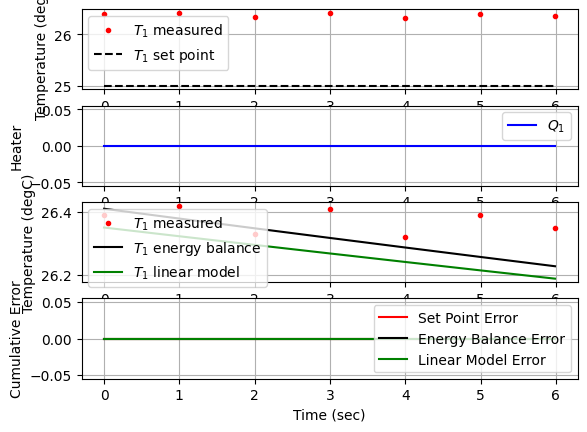

1/1 [==============================] - 0s 16ms/step
   8.0  25.00  26.38   0.00  -0.47   0.00   0.00


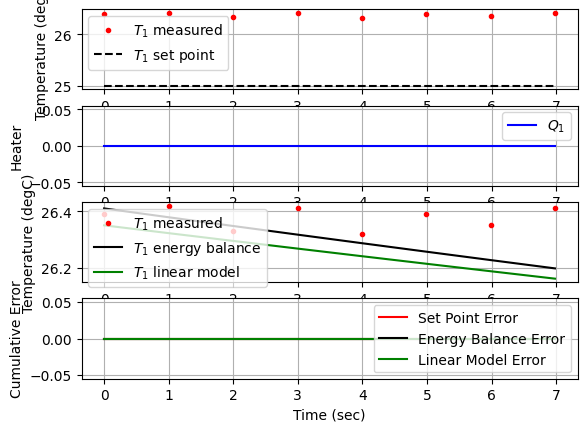

1/1 [==============================] - 0s 31ms/step
   9.0  25.00  26.40   0.00  -0.48   0.00  -0.00


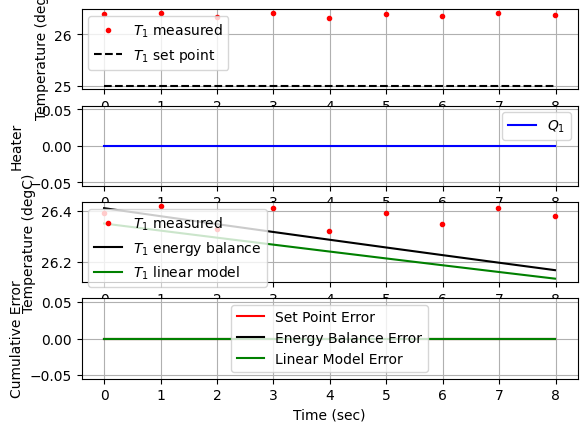

1/1 [==============================] - 0s 16ms/step
  10.0  25.00  26.38   0.00  -0.47   0.00   0.00


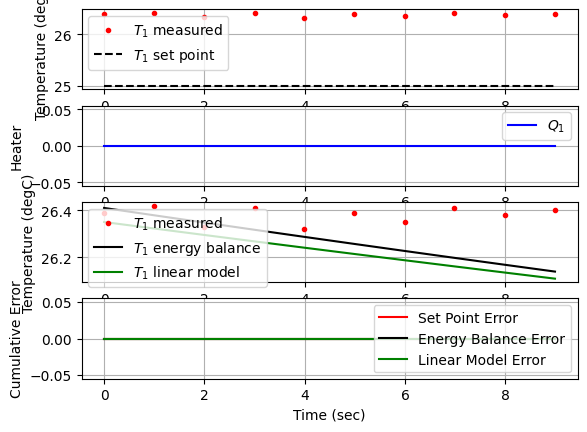

1/1 [==============================] - 0s 16ms/step
  11.0  25.00  26.39   0.00  -0.47   0.00  -0.00


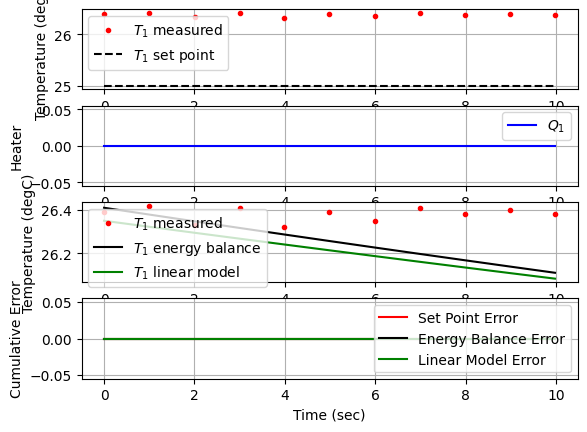

1/1 [==============================] - 0s 16ms/step
  12.0  25.00  26.37   0.00  -0.47   0.00   0.00


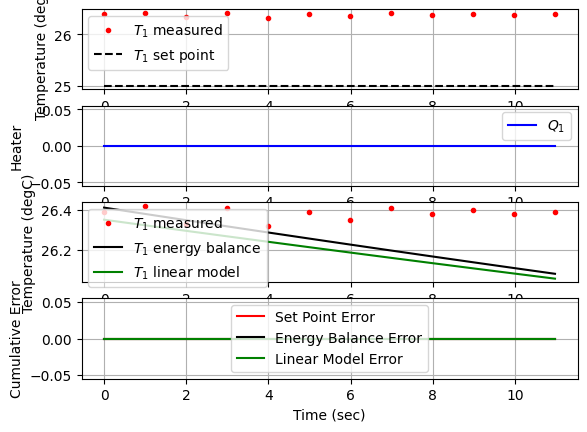

1/1 [==============================] - 0s 16ms/step
  13.0  25.00  26.37   0.00  -0.47   0.00  -0.00


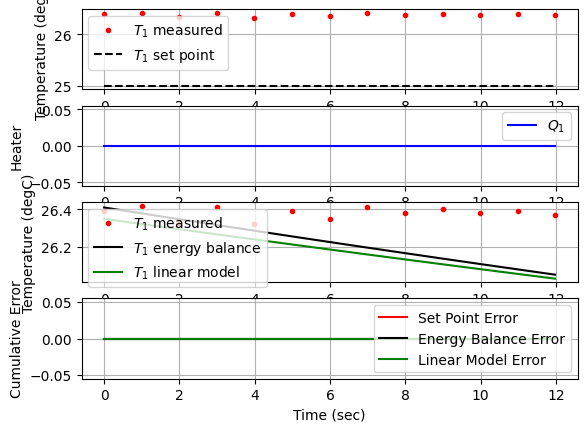

1/1 [==============================] - 0s 31ms/step
  14.0  25.00  26.36   0.00  -0.46   0.00   0.00


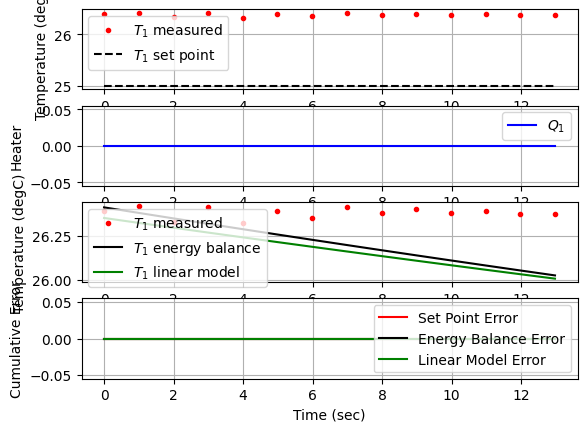

1/1 [==============================] - 0s 31ms/step
  15.0  25.00  26.38   0.00  -0.47   0.00  -0.00


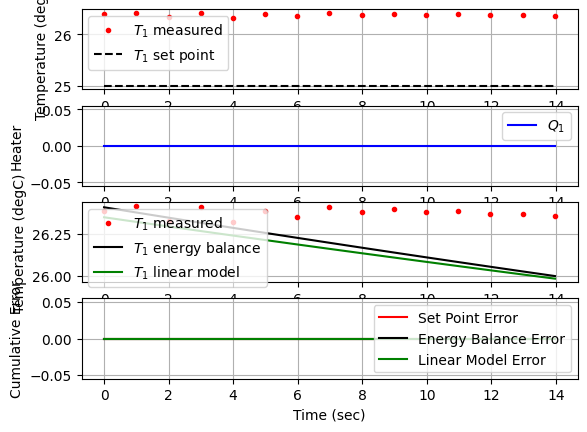

1/1 [==============================] - 0s 16ms/step
  16.0  25.00  26.41   0.00  -0.48   0.00  -0.00


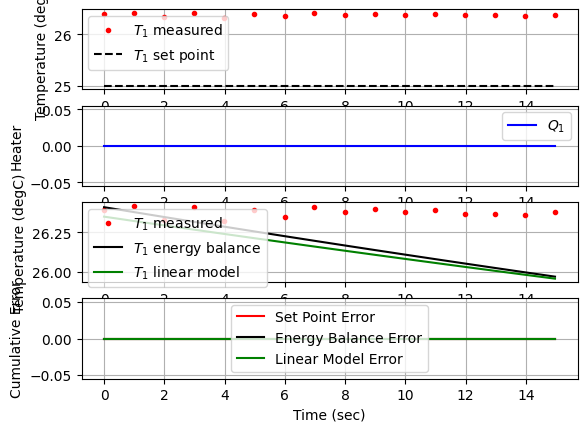

1/1 [==============================] - 0s 16ms/step
  17.0  25.00  26.37   0.00  -0.47   0.00   0.00


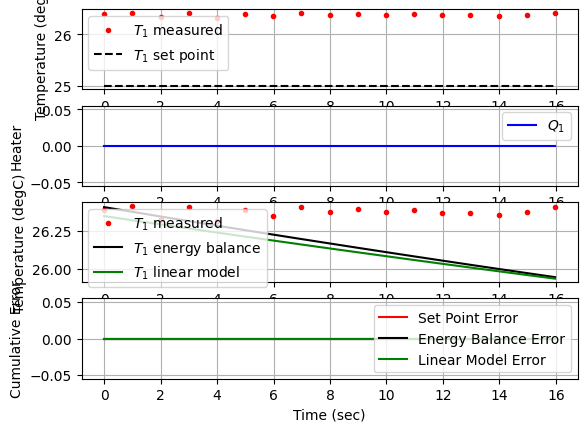

1/1 [==============================] - 0s 16ms/step
  18.0  25.00  26.40   0.00  -0.48   0.00  -0.00


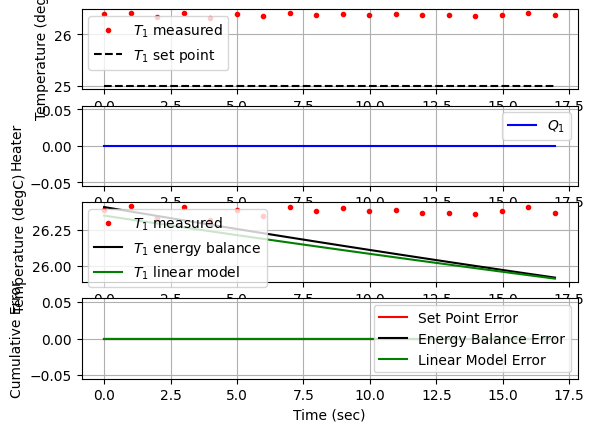

1/1 [==============================] - 0s 25ms/step
  19.0  25.00  26.41   0.00  -0.48   0.00  -0.00


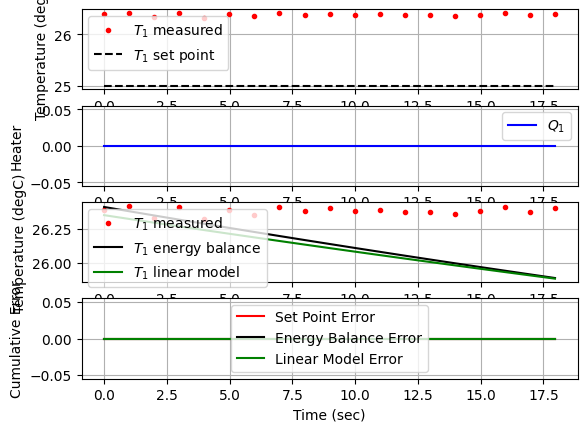

1/1 [==============================] - 0s 16ms/step
  20.0  25.00  26.36   0.00  -0.46   0.00   0.01


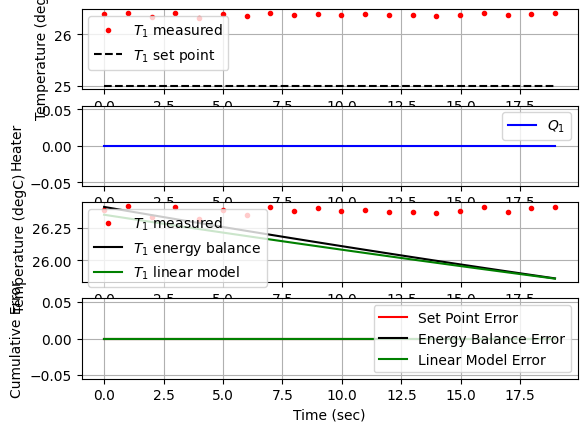

1/1 [==============================] - 0s 16ms/step
  20.9  25.00  26.38   0.00  -0.47   0.00  -0.00


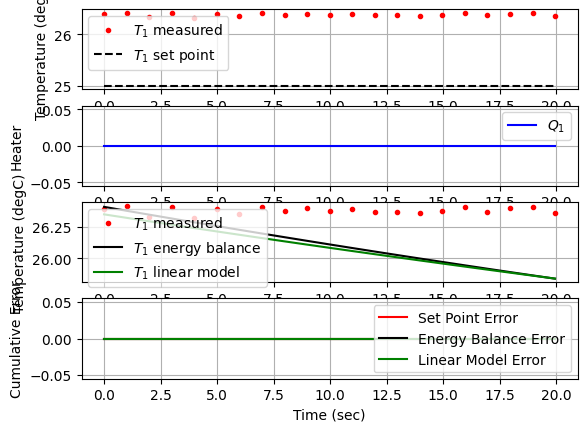

1/1 [==============================] - 0s 16ms/step
  21.9  25.00  26.35   0.00  -0.46   0.00   0.00


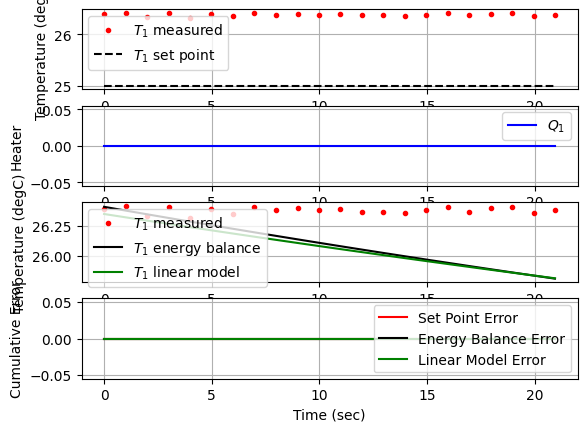

1/1 [==============================] - 0s 17ms/step
  22.9  25.00  26.39   0.00  -0.47   0.00  -0.00


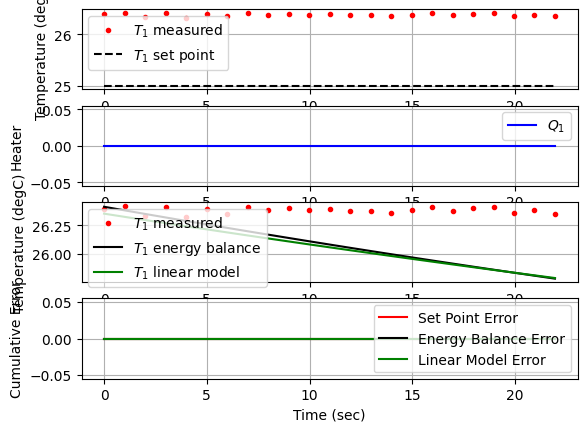

1/1 [==============================] - 0s 16ms/step
  23.9  25.00  26.35   0.00  -0.46   0.00   0.00


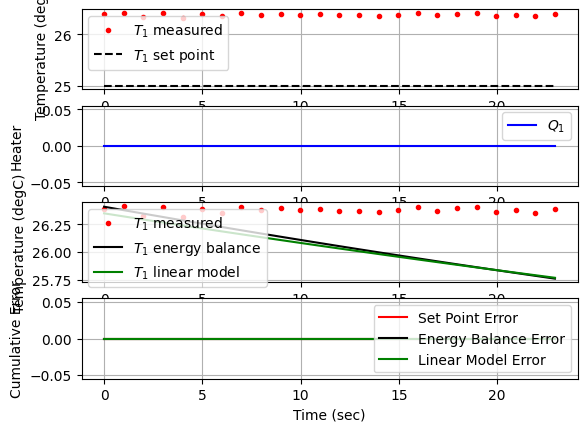

1/1 [==============================] - 0s 16ms/step
  24.9  25.00  26.38   0.00  -0.47   0.00  -0.00


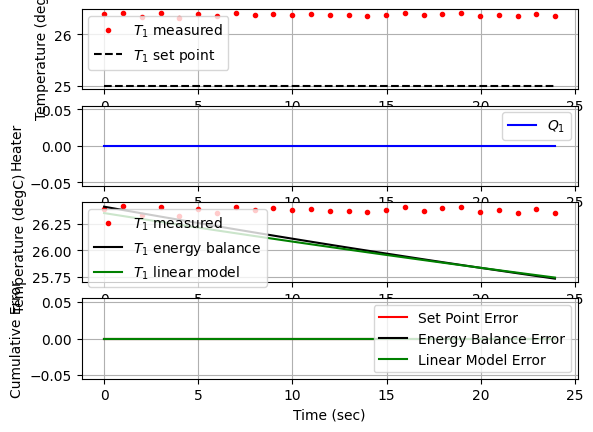

1/1 [==============================] - 0s 16ms/step
  25.9  25.00  26.40   0.00  -0.48   0.00  -0.00


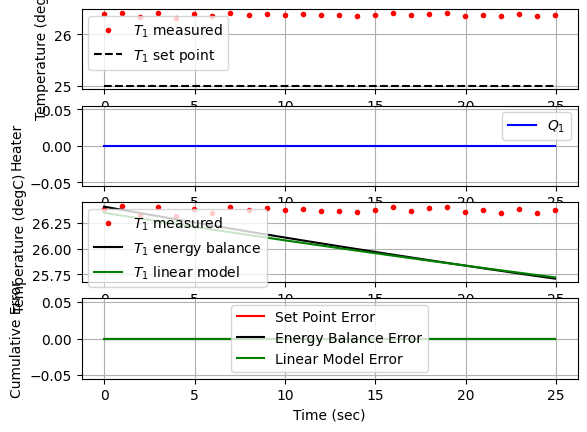

1/1 [==============================] - 0s 18ms/step
  26.9  25.00  26.40   0.00  -0.48   0.00  -0.00


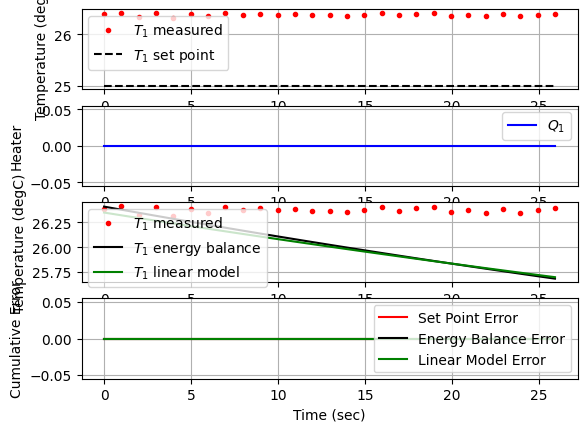

1/1 [==============================] - 0s 20ms/step
  27.9  25.00  26.36   0.00  -0.46   0.00   0.00


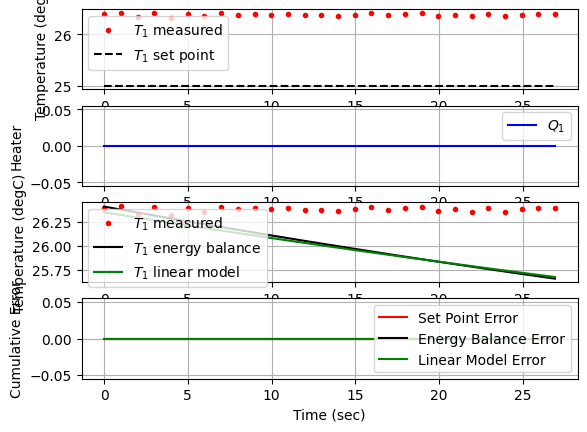

1/1 [==============================] - 0s 16ms/step
  28.9  25.00  26.43   0.00  -0.49   0.00  -0.01


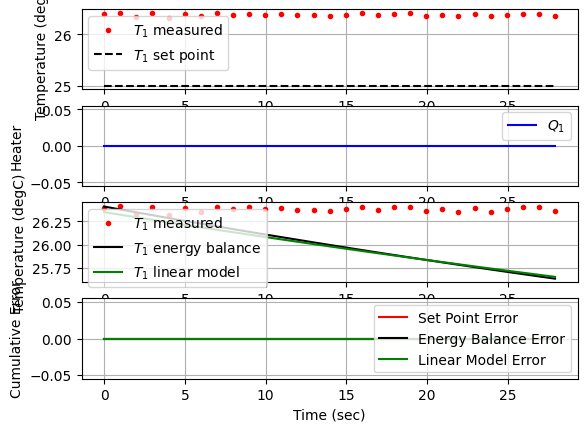

1/1 [==============================] - 0s 31ms/step
  29.9  25.00  26.43   0.00  -0.49   0.00  -0.00


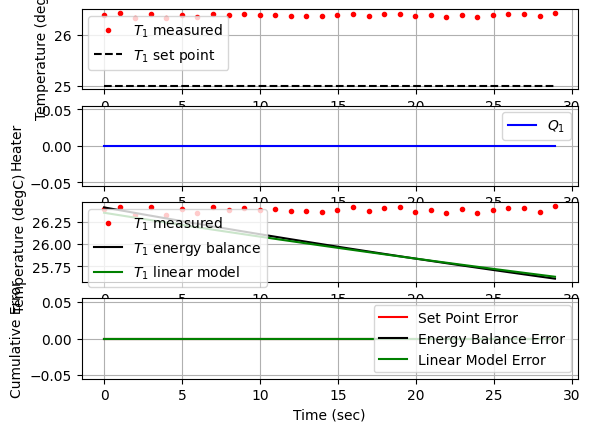

1/1 [==============================] - 0s 16ms/step
  30.9  25.00  26.38   0.00  -0.47   0.00   0.01


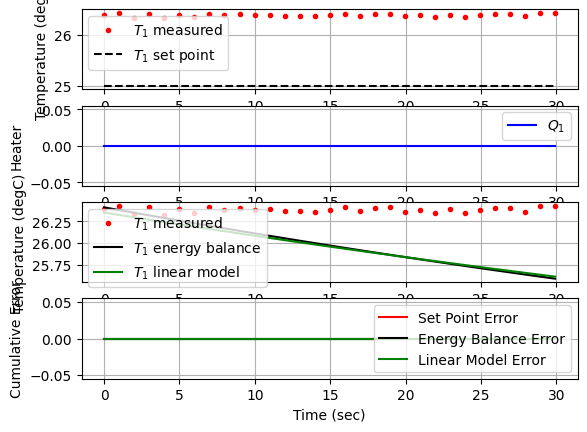

1/1 [==============================] - 0s 31ms/step
  31.9  25.00  26.40   0.00  -0.48   0.00  -0.00


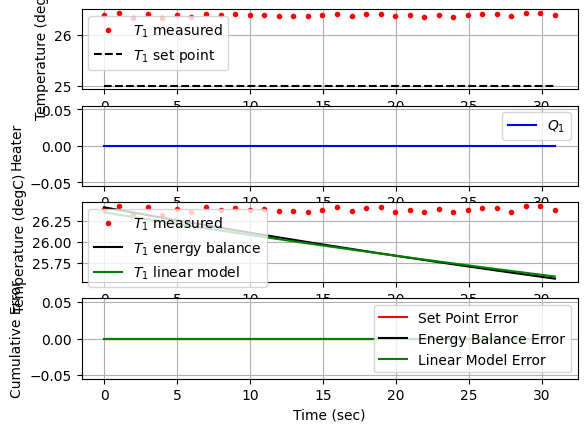

1/1 [==============================] - 0s 16ms/step
  32.9  25.00  26.31   0.00  -0.45   0.00   0.01


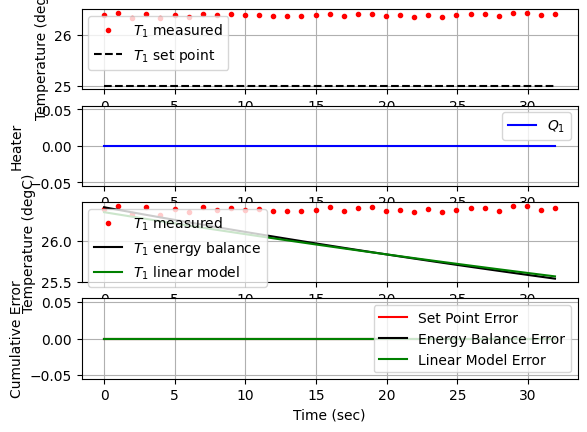

1/1 [==============================] - 0s 31ms/step
  33.9  25.00  26.38   0.00  -0.47   0.00  -0.01


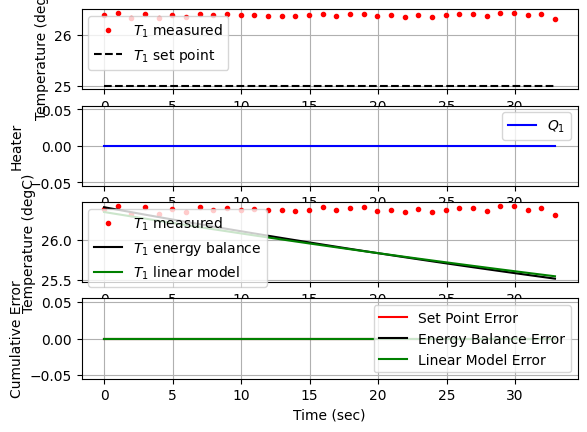

1/1 [==============================] - 0s 16ms/step
  34.9  25.00  26.34   0.00  -0.46   0.00   0.00


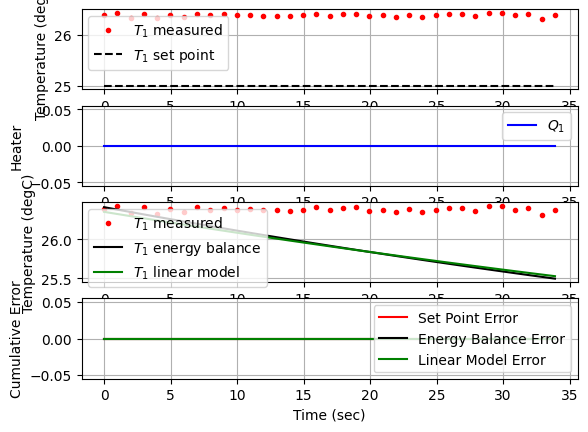

1/1 [==============================] - 0s 24ms/step
  35.9  25.00  26.35   0.00  -0.46   0.00  -0.00


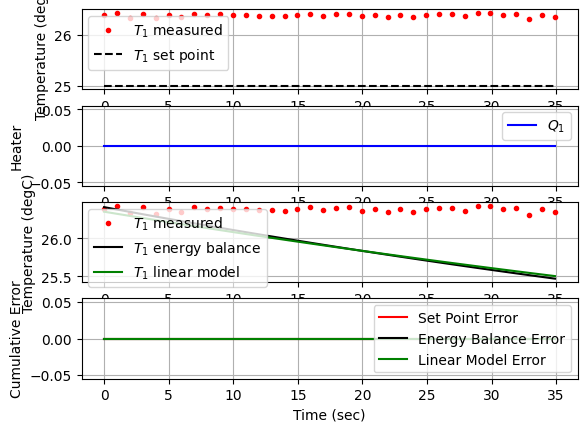

1/1 [==============================] - 0s 16ms/step
  36.9  25.00  26.40   0.00  -0.48   0.00  -0.01


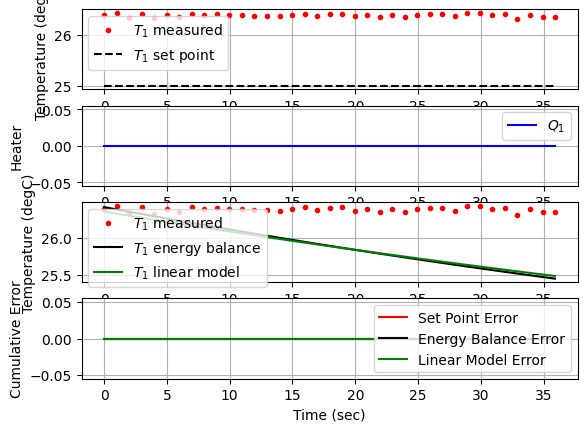

1/1 [==============================] - 0s 16ms/step
  37.9  25.00  26.32   0.00  -0.45   0.00   0.01


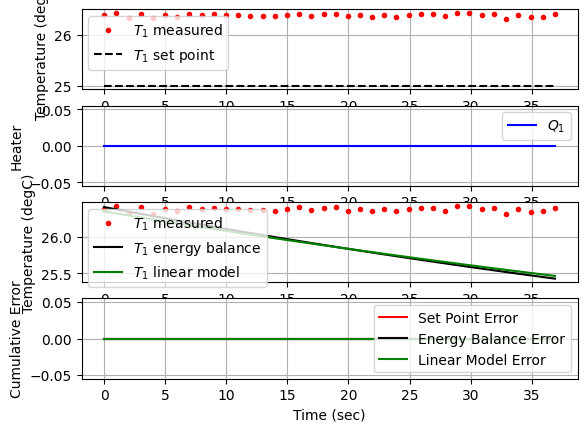

1/1 [==============================] - 0s 14ms/step
  38.9  25.00  26.35   0.00  -0.46   0.00  -0.00


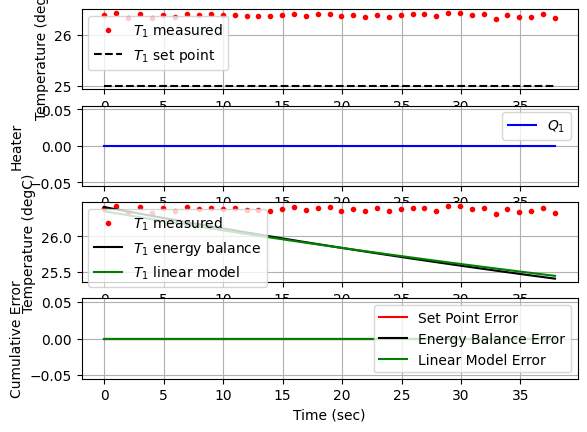

1/1 [==============================] - 0s 14ms/step
  39.9  25.00  26.35   0.00  -0.46   0.00  -0.00


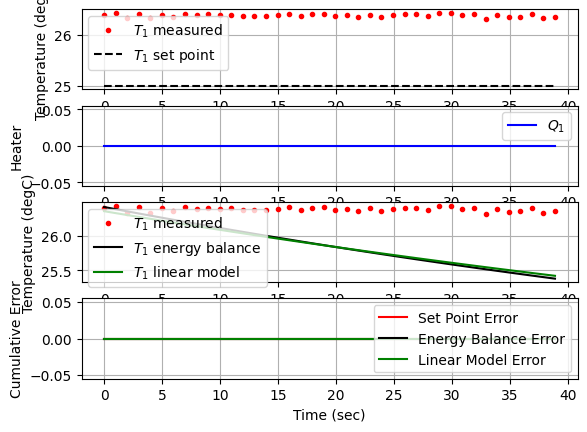

1/1 [==============================] - 0s 16ms/step
  40.9  25.00  26.40   0.00  -0.48   0.00  -0.01


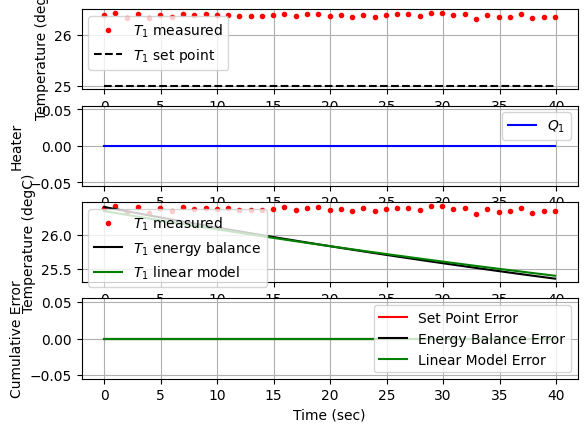

1/1 [==============================] - 0s 17ms/step
  41.9  25.00  26.42   0.00  -0.48   0.00  -0.00


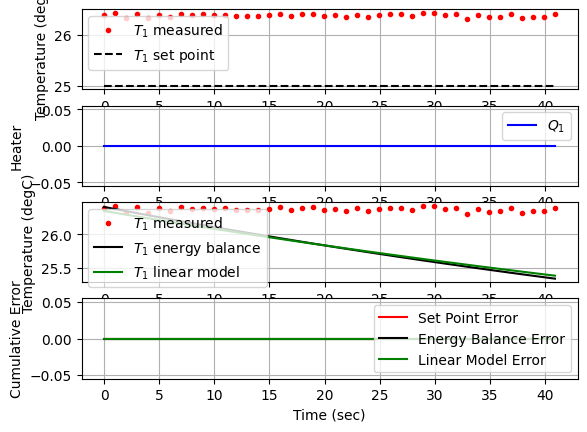

1/1 [==============================] - 0s 16ms/step
  42.9  25.00  26.34   0.00  -0.46   0.00   0.01


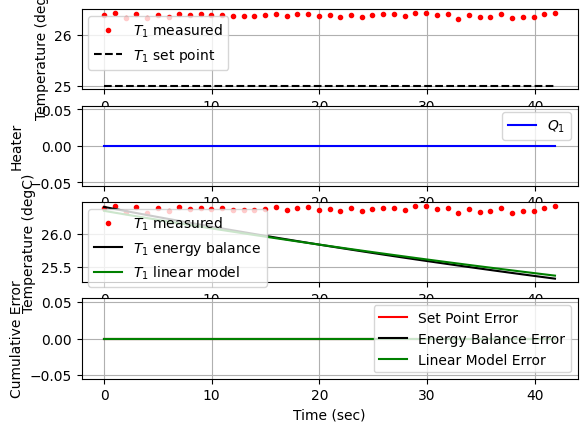

1/1 [==============================] - 0s 16ms/step
  43.9  25.00  26.40   0.00  -0.48   0.00  -0.01


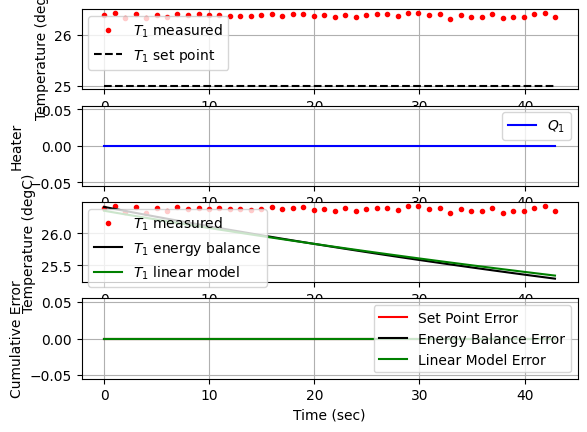

1/1 [==============================] - 0s 16ms/step
  44.9  25.00  26.35   0.00  -0.46   0.00   0.01


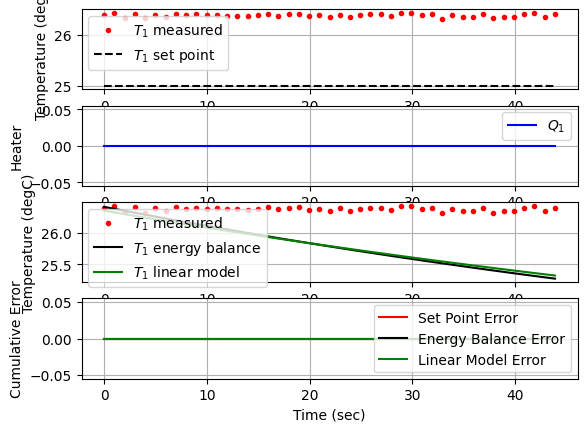

1/1 [==============================] - 0s 31ms/step
  45.9  25.00  26.44   0.00  -0.49   0.00  -0.01


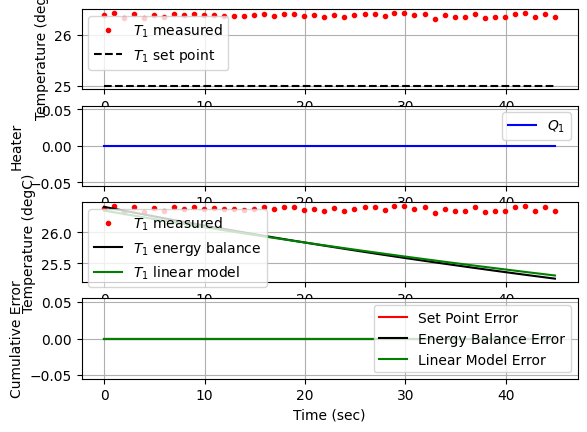

1/1 [==============================] - 0s 16ms/step
  46.9  25.00  26.39   0.00  -0.47   0.00   0.01


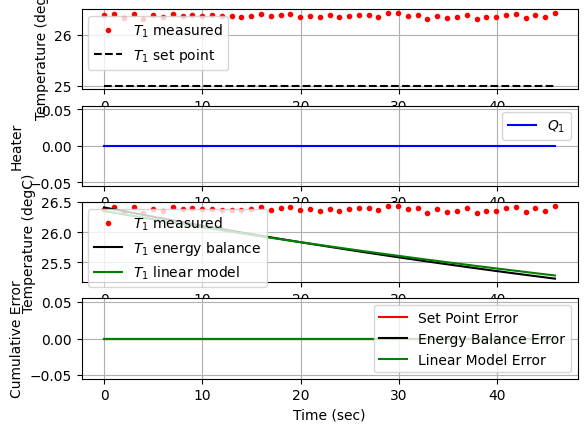

1/1 [==============================] - 0s 32ms/step
  47.9  25.00  26.41   0.00  -0.48   0.00  -0.00


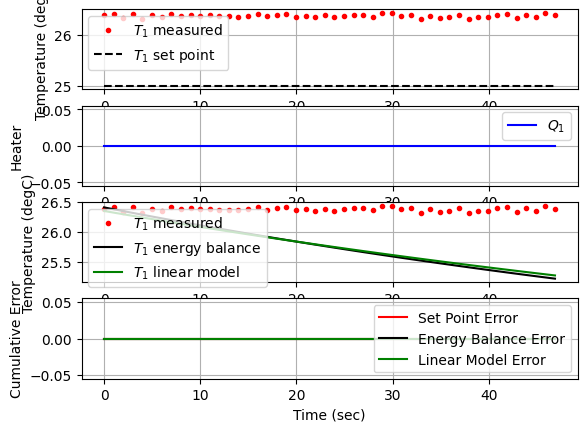

1/1 [==============================] - 0s 16ms/step
  48.9  25.00  26.44   0.00  -0.49   0.00  -0.00


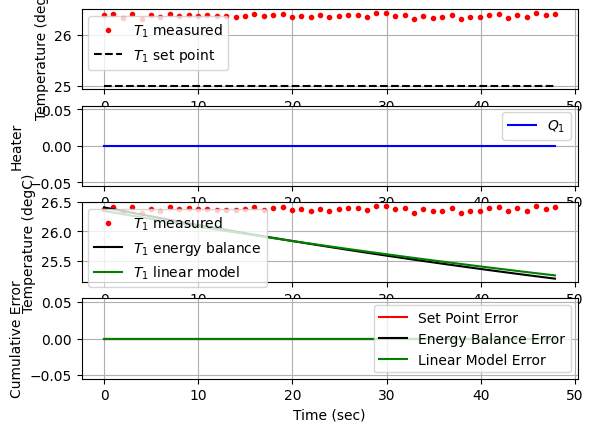

1/1 [==============================] - 0s 24ms/step
  49.9  25.00  26.35   0.00  -0.46   0.00   0.01


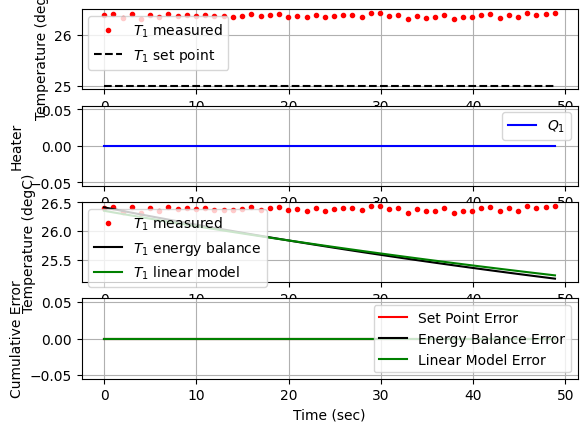

1/1 [==============================] - 0s 16ms/step
  50.9  25.00  26.39   0.00  -0.47   0.00  -0.00


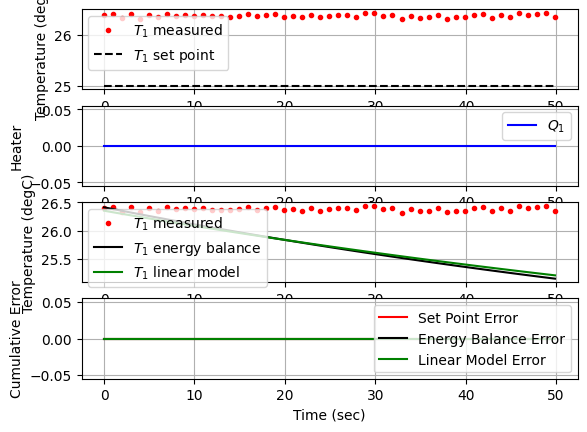

1/1 [==============================] - 0s 16ms/step
  51.9  25.00  26.40   0.00  -0.48   0.00  -0.00


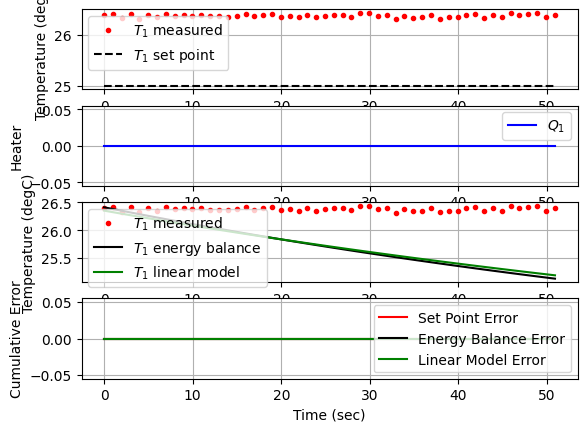

1/1 [==============================] - 0s 32ms/step
  52.9  25.00  26.45   0.00  -0.49   0.00  -0.01


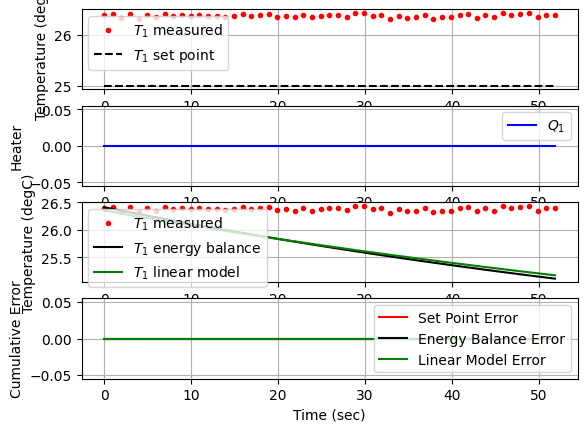

1/1 [==============================] - 0s 31ms/step
  53.9  25.00  26.35   0.00  -0.46   0.00   0.01


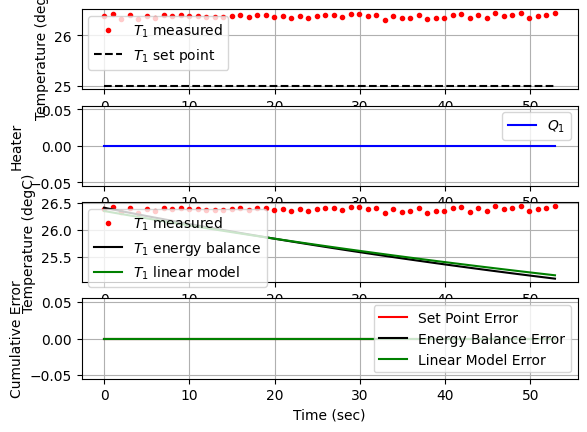

1/1 [==============================] - 0s 31ms/step
  54.9  25.00  26.45   0.00  -0.49   0.00  -0.01


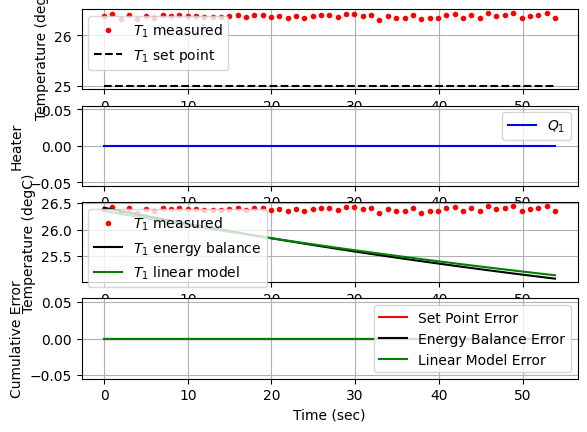

1/1 [==============================] - 0s 16ms/step
  55.9  25.00  26.36   0.00  -0.46   0.00   0.01


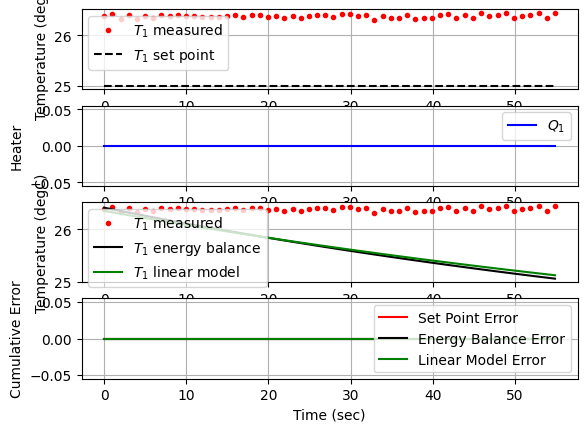

1/1 [==============================] - 0s 24ms/step
  56.9  25.00  26.38   0.00  -0.47   0.00  -0.00


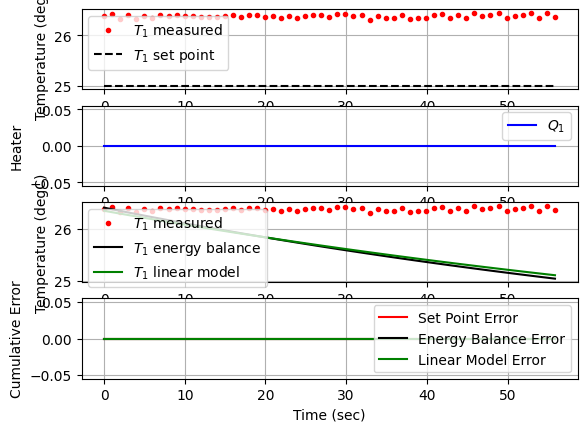

1/1 [==============================] - 0s 33ms/step
  57.9  25.00  26.36   0.00  -0.46   0.00   0.00


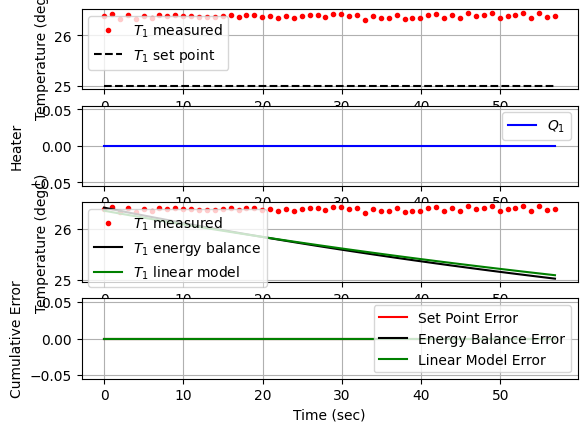

1/1 [==============================] - 0s 31ms/step
  58.9  25.00  26.42   0.00  -0.48   0.00  -0.01


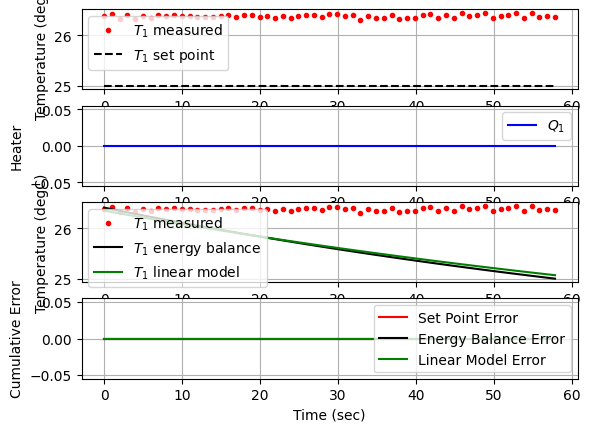

1/1 [==============================] - 0s 27ms/step
  59.9  45.00  26.39  16.18   6.63   9.54   0.00


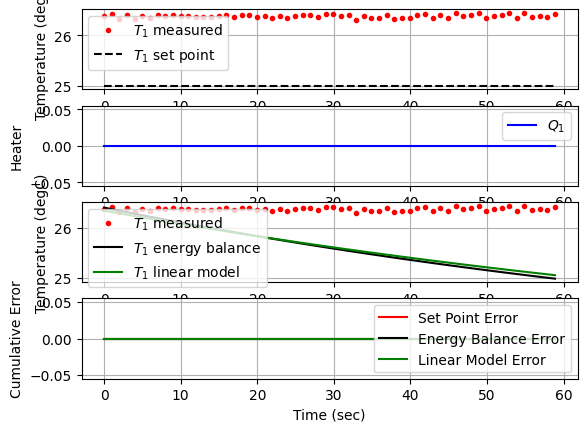

1/1 [==============================] - 0s 29ms/step
  60.9  45.00  26.45  25.79   6.61  19.19  -0.01


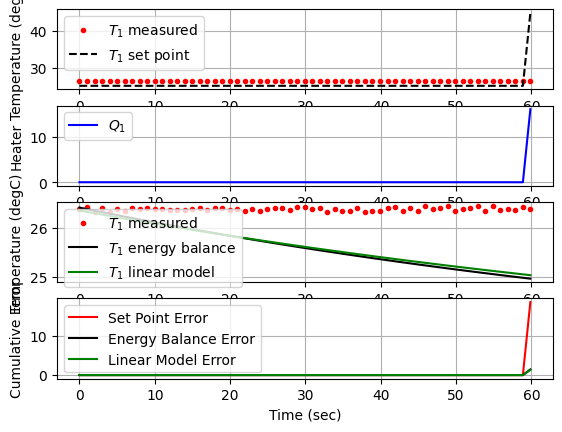

1/1 [==============================] - 0s 34ms/step
  61.9  45.00  26.36  35.43   6.64  28.79   0.01


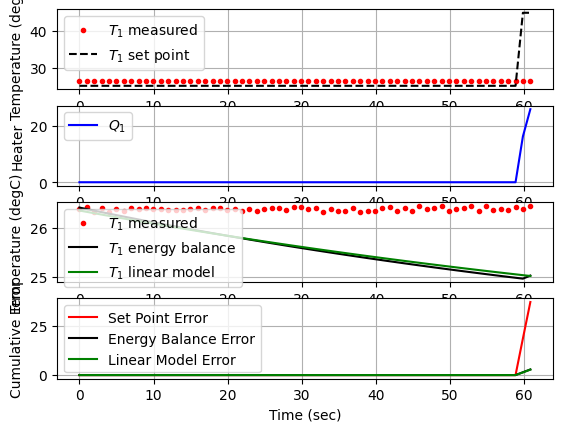

1/1 [==============================] - 0s 21ms/step
  62.9  45.00  26.34  45.07   6.65  38.43   0.00


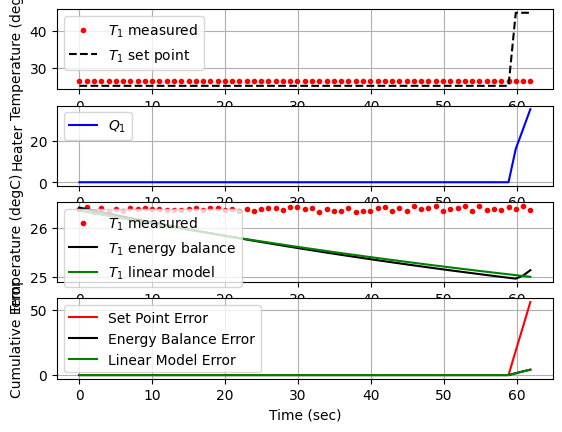

1/1 [==============================] - 0s 16ms/step
  63.9  45.00  26.39  54.60   6.63  47.98  -0.01


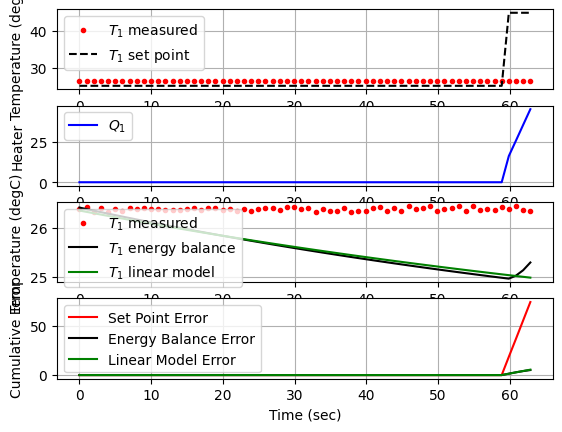

1/1 [==============================] - 0s 16ms/step
  64.8  45.00  26.42  64.12   6.62  57.50  -0.00


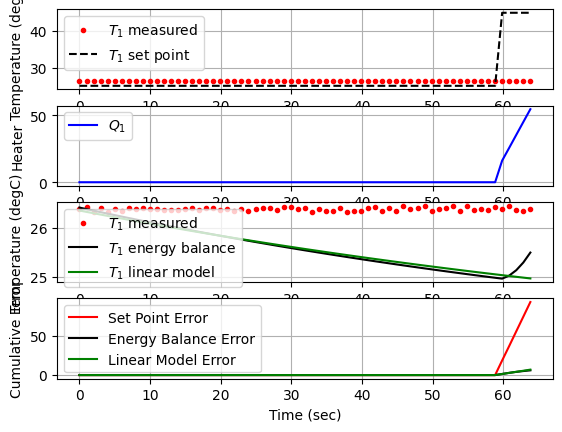

1/1 [==============================] - 0s 16ms/step
  65.9  45.00  26.39  73.78   6.63  67.15   0.00


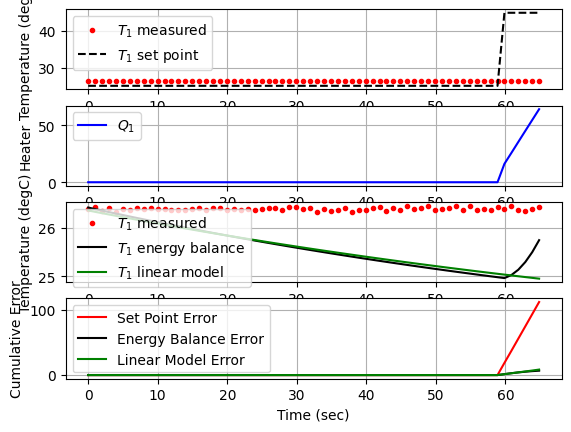

1/1 [==============================] - 0s 16ms/step
  66.9  45.00  26.40  83.42   6.62  76.79  -0.00


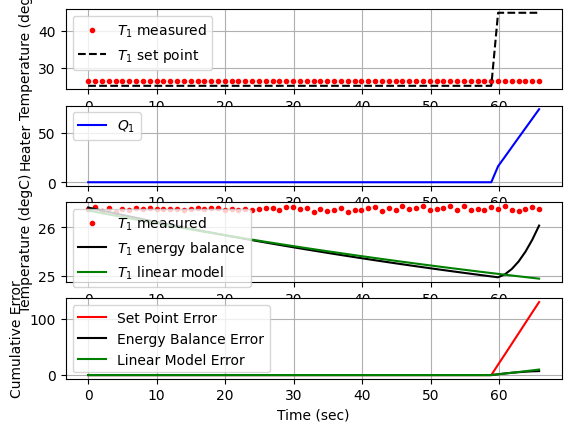

1/1 [==============================] - 0s 32ms/step
  67.9  45.00  26.45  93.01   6.61  86.41  -0.01


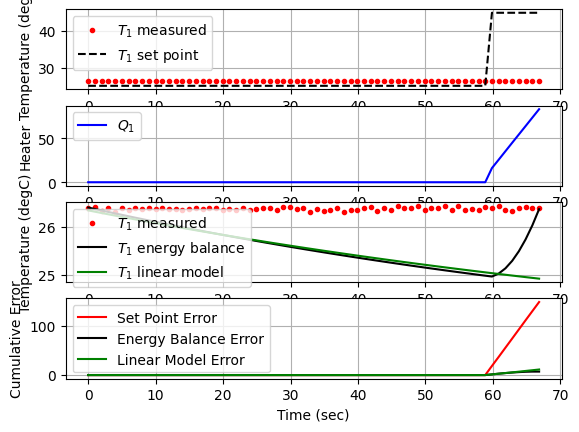

1/1 [==============================] - 0s 16ms/step
  68.9  45.00  26.42 100.00   6.62  86.41   0.00


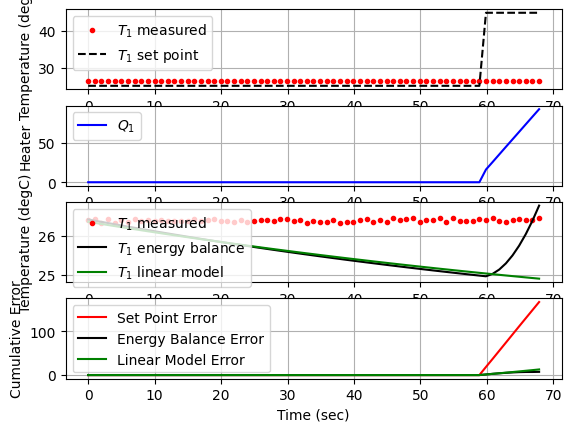

1/1 [==============================] - 0s 32ms/step
  69.9  45.00  26.41 100.00   6.62  86.41   0.00


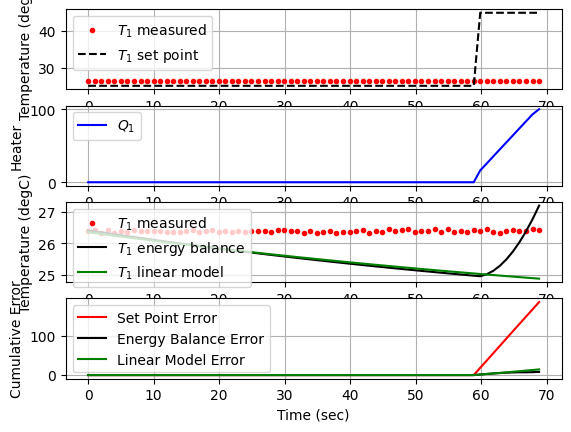

1/1 [==============================] - 0s 16ms/step
  70.8  45.00  26.42 100.00   6.62  86.41  -0.00


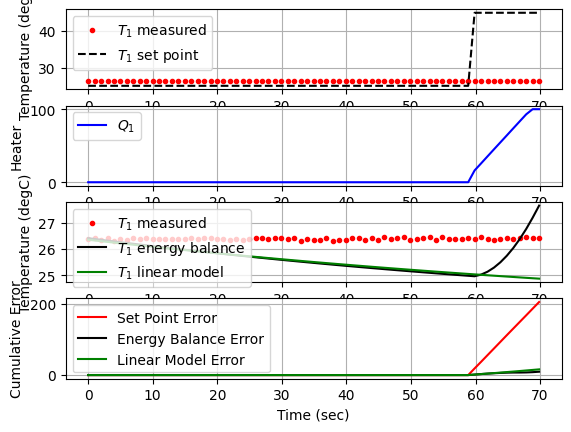

1/1 [==============================] - 0s 16ms/step
  71.8  45.00  26.37 100.00   6.63  86.41   0.01


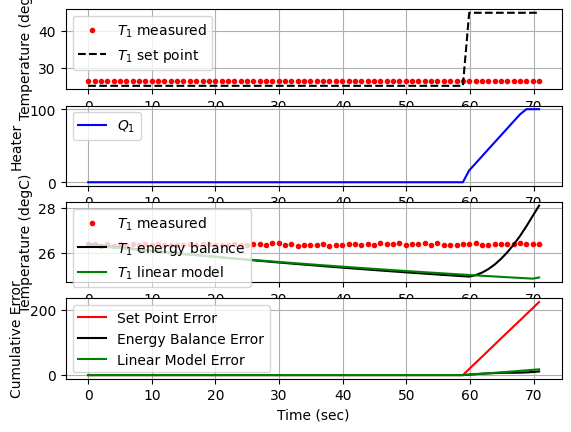

1/1 [==============================] - 0s 16ms/step
  72.8  45.00  26.38 100.00   6.63  86.41  -0.00


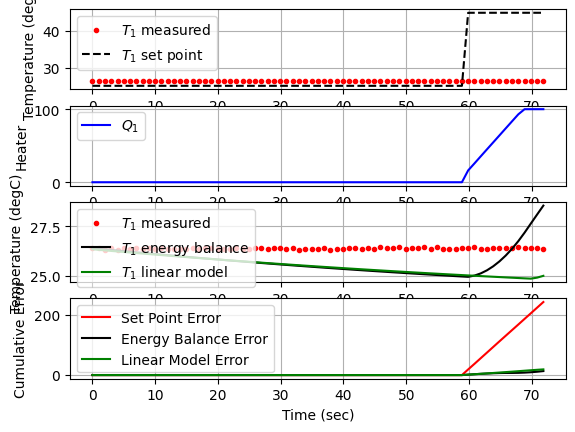

1/1 [==============================] - 0s 16ms/step
  73.8  45.00  26.36 100.00   6.64  86.41   0.00


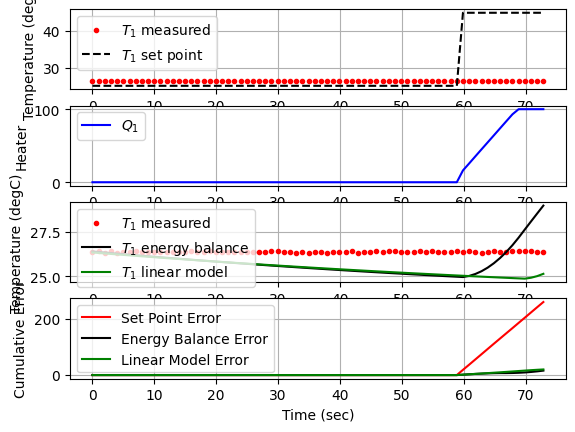

1/1 [==============================] - 0s 16ms/step
  74.8  45.00  26.43 100.00   6.61  86.41  -0.01


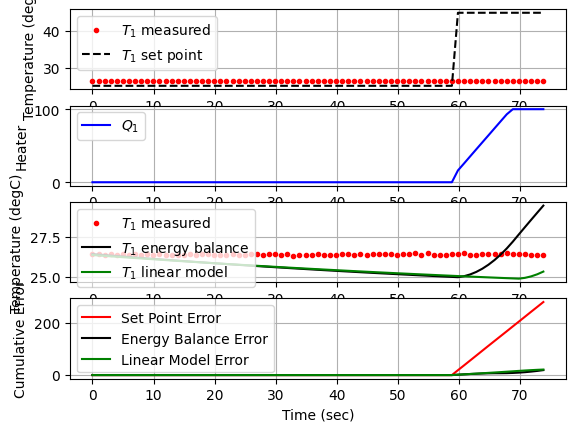

1/1 [==============================] - 0s 31ms/step


In [ ]:
######################################################
# Do not adjust anything below this point            #
######################################################

# Connect to Arduino
a = itclab.iTCLab()
#a.encode('utf-8').strip()#modification error
# Turn LED on
print('LED On')
a.LED(100)

# Run time in minutes
run_time = 15.0

# Number of cycles
loops = int(60.0*run_time)
tm = np.zeros(loops)

# Temperature
# set point (degC)
Tsp1 = np.ones(loops) * 25.0 
Tsp1[60:] = 45.0
Tsp1[360:] = 30.0
Tsp1[660:] = 35.0
T1 = np.ones(loops) * a.T1 # measured T (degC)
error_sp = np.zeros(loops)

Tsp2 = np.ones(loops) * 23.0 # set point (degC)
T2 = np.ones(loops) * a.T2 # measured T (degC)

# Predictions
Tp = np.ones(loops) * a.T1
error_eb = np.zeros(loops)
Tpl = np.ones(loops) * a.T1
error_fopdt = np.zeros(loops)

# impulse tests (0 - 100%)
Q1 = np.ones(loops) * 0.0
Q2 = np.ones(loops) * 0.0

print('Running Main Loop. Ctrl-C to end.')
print('  Time     SP     PV     Q1   =  P   +  I  +   D')
print(('{:6.1f} {:6.2f} {:6.2f} ' + \
       '{:6.2f} {:6.2f} {:6.2f} {:6.2f}').format( \
           tm[0],Tsp1[0],T1[0], \
           Q1[0],0.0,0.0,0.0))

# Create plot
plt.figure(figsize=(10,7))
plt.ion()
plt.show()

# Main Loop
start_time = time.time()
prev_time = start_time
# Integral error
ierr = 0.0
try:
    for i in range(1,loops):
        # Sleep time
        sleep_max = 1.0
        sleep = sleep_max - (time.time() - prev_time)
        if sleep>=0.01:
            time.sleep(sleep-0.01)
        else:
            time.sleep(0.01)

        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time

        # Read temperatures in Kelvin 
        T1[i] = a.T1
        T2[i] = a.T2

        # Simulate one time step with Energy Balance
        Tnext = odeint(heat,Tp[i-1]+273.15,[0,dt],args=(Q1[i-1],))
        Tp[i] = Tnext[1]-273.15

        # Simulate one time step with linear FOPDT model
        z = np.exp(-dt/tauP)
        Tpl[i] = (Tpl[i-1]-Tss) * z \
                 + (Q1[max(0,i-int(thetaP)-1)]-Qss)*(1-z)*Kp \
                 + Tss

        # Calculate PID Output (Choose one of them)
        # 1. Manually Choosen
#         [Q1[i],P,ierr,D] = pid(Tsp1[i],T1[i],T1[i-1],ierr,dt)

        # 2. Based on Deep Learning Result
        [Q1[i],P,ierr,D] = pid_dl(Tsp1[i],T1[i],T1[i-1],ierr,dt)

        # Start setpoint error accumulation after 1 minute (60 seconds)
        if i>=60:
            error_eb[i] = error_eb[i-1] + abs(Tp[i]-T1[i])
            error_fopdt[i] = error_fopdt[i-1] + abs(Tpl[i]-T1[i])
            error_sp[i] = error_sp[i-1] + abs(Tsp1[i]-T1[i])

        # Write output (0-100)
        a.Q1(Q1[i])
        a.Q2(0.0)

        # Print line of data
        print(('{:6.1f} {:6.2f} {:6.2f} ' + \
              '{:6.2f} {:6.2f} {:6.2f} {:6.2f}').format( \
                  tm[i],Tsp1[i],T1[i], \
                  Q1[i],P,ierr,D))
        
        # Publish data to MQTT Broker
        pub_sp = client.publish('SetPoint', Tsp1[i])
        pub_pv1 = client.publish('suhu1', T1[i])
        pub_op = client.publish('Nilai_op', Q1[i])

        # Plot
        plt.clf()
        ax=plt.subplot(4,1,1)
        ax.grid()
        plt.plot(tm[0:i],T1[0:i],'r.',label=r'$T_1$ measured')
        plt.plot(tm[0:i],Tsp1[0:i],'k--',label=r'$T_1$ set point')
        plt.ylabel('Temperature (degC)')
        plt.legend(loc=2)
        ax=plt.subplot(4,1,2)
        ax.grid()
        plt.plot(tm[0:i],Q1[0:i],'b-',label=r'$Q_1$')
        plt.ylabel('Heater')
        plt.legend(loc='best')
        ax=plt.subplot(4,1,3)
        ax.grid()
        plt.plot(tm[0:i],T1[0:i],'r.',label=r'$T_1$ measured')
        plt.plot(tm[0:i],Tp[0:i],'k-',label=r'$T_1$ energy balance')
        plt.plot(tm[0:i],Tpl[0:i],'g-',label=r'$T_1$ linear model')
        plt.ylabel('Temperature (degC)')
        plt.legend(loc=2)
        ax=plt.subplot(4,1,4)
        ax.grid()
        plt.plot(tm[0:i],error_sp[0:i],'r-',label='Set Point Error')
        plt.plot(tm[0:i],error_eb[0:i],'k-',label='Energy Balance Error')
        plt.plot(tm[0:i],error_fopdt[0:i],'g-',label='Linear Model Error')
        plt.ylabel('Cumulative Error')
        plt.legend(loc='best')
        plt.xlabel('Time (sec)')
        plt.draw()
        plt.pause(0.05)

    # Turn off heaters
    a.Q1(0)
    a.Q2(0)
    # Save figure
    plt.savefig('test_PID_dl.png')

# Allow user to end loop with Ctrl-C           
except KeyboardInterrupt:
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Shutting down')
    a.close()
    plt.savefig('test_PID_dl.png')

# Make sure serial connection still closes when there's an error
except:           
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Error: Shutting down')
    a.close()
    plt.savefig('test_PID_dl.png')
    raise

a.close()

In [ ]:
a.close()